# KL4 Structure Analysis

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [3]:
from collections import OrderedDict
from ipywidgets import interact, fixed
from pathlib import Path
import re
import warnings 

from Bio import SeqIO
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt
import nglview
import pandas as pd

warnings.filterwarnings(action="ignore")

In [4]:
DATA_DIR = Path().resolve().parent.joinpath("data")
RESULTS_DIR = Path().resolve().parent.joinpath("results")
PROTEIN_NAME = "KLF4"
PROTEIN_PDB_ID = "6vtx"

title_font = {"size": "16", "weight": "normal"}
axis_font = {"size": "14"}

## Avg. occurences of amino acids across human proteome

In [5]:
# I downloaded all reviewed human proteins from uniprot in order to count the avg
# occurence of each amino acid to compare it to the occurences of amino acids in KLF4.
fasta = SeqIO.parse(open(DATA_DIR.joinpath("uniprot-filtered-organism__Homo+sapiens+(Human)+[9606]_+AND+review--.dnas")), format="fasta")
proteins = []
for protein in fasta:
    amino_acid_dict = {}
    for amino_acid in protein.seq:
        amino_acid_dict[amino_acid] = amino_acid_dict.get(amino_acid, 0) + 1
    proteins.append(amino_acid_dict)
mean_occurences = pd.DataFrame(proteins).mean().to_dict()

## Homolog analysis

In [6]:
# Check how many different organisms the detected homologs come from
fasta = SeqIO.parse(open(DATA_DIR.joinpath("KLF4_HUMAN_homologs.fasta")), format="fasta")
organisms = set()
for homolog in fasta:
    search = re.search("\[.*\]", homolog.description)
    if search:
        organism = search.group(0)[1:-1]
        organisms.add(organism)
print(f"Homologs stem from {len(organisms)} different organisms")

Homologs stem from 85 different organisms


## Amino Acid Occurences

In [7]:
# Fasta downloaded from: https://www.uniprot.org/uniprot/O43474
fasta = SeqIO.parse(open(DATA_DIR.joinpath("KLF4_HUMAN.fasta")), format="fasta")

In [8]:
klf4 = next(fasta)

In [9]:
len(klf4.seq)

513

In [10]:
amino_acid_dict = {}
for amino_acid in klf4.seq:
    amino_acid_dict[amino_acid] = amino_acid_dict.get(amino_acid, 0) + 1
# Retrieve an ordered dict, sorted by the number of occurences for each amino acid
amino_acid_dict = OrderedDict(sorted(amino_acid_dict.items(), key=lambda k:k[1]))

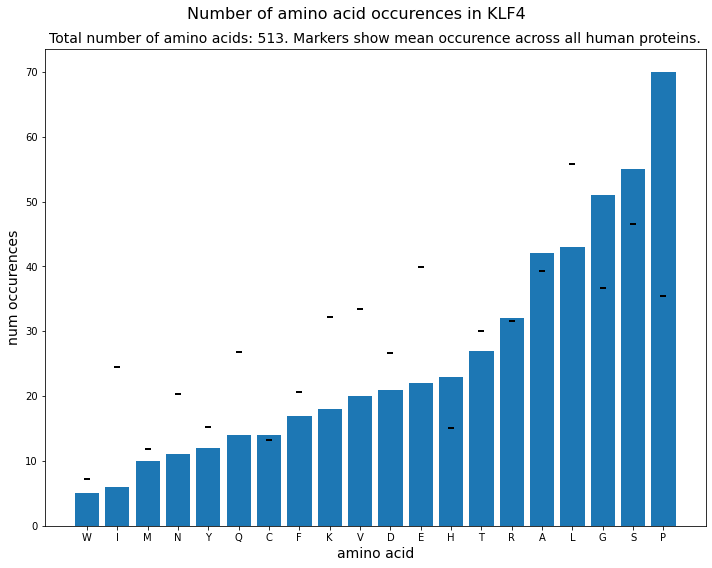

In [11]:
plt.figure(figsize=(10,8))
for amino_acid, count in amino_acid_dict.items():
    plt.bar(amino_acid, count, color="#1d77b4")
    plt.scatter(amino_acid, mean_occurences[amino_acid], marker='_', color='black', linewidths=2)
plt.suptitle(f"Number of amino acid occurences in {PROTEIN_NAME}", **title_font)
plt.title(f"Total number of amino acids: {len(klf4.seq)}. Markers show mean occurence across all human proteins.", **axis_font)
plt.xlabel("amino acid", **axis_font)
plt.ylabel("num occurences", **axis_font)
plt.savefig(RESULTS_DIR.joinpath(f"num_aa_occurences_{PROTEIN_NAME}.png"))
plt.tight_layout()
plt.show()

## Visualize

In [12]:
representations = ["backbone", "ball+stick", "cartoon", "line", "point", "ribbon", "surface"]

def change_representation(view, representation, coloring="atomindex"):
    view.clear()
    view.add_representation(representation, color_scheme=coloring)

In [13]:
parser = PDBParser()
structure = parser.get_structure("protein", str(DATA_DIR/f"{PROTEIN_PDB_ID}.pdb"))
structure = structure[0]

In [14]:
# Default view in complex with DNA
view = nglview.show_biopython(structure, default_representation=True)
view

NGLWidget()

In [15]:
# Show the protein only in cartoon
view = nglview.show_biopython(structure["A"])
change_representation(view, "cartoon")
view

NGLWidget()

In [16]:
# Show the protein only in ribbon
view = nglview.show_biopython(structure["A"])
change_representation(view, "ribbon")
view

NGLWidget()

In [17]:
# Show the protein only in ball+stick
view = nglview.show_biopython(structure["A"])
change_representation(view, "ball+stick")
view

NGLWidget()

In [18]:
# Show the protein colored by secondary structure
view = nglview.show_biopython(structure["A"])
change_representation(view, "cartoon", "sstruc")
view

NGLWidget()

In [19]:
# Show the protein colored by hydrophobicity
# -- colored from red (hydrophilic) to green (hydrophobic)
view = nglview.show_biopython(structure["A"])
change_representation(view, "ball+stick", "hydrophobicity")
view

NGLWidget()

In [20]:
# Show the protein surface to detect binding pockets
view = nglview.show_biopython(structure["A"])
change_representation(view, "surface")
view

NGLWidget()

In [ ]:
# Dynamic widget
interact(
    change_representation, 
    view=fixed(view), 
    representation=representations, 
    coloring=nglview.color.COLOR_SCHEMES)
view

In [ ]:
view.render_image(trim=True);
view.download_image(filename=f"{PROTEIN_NAME}_")